## 슬개골 포함ver. Train

In [ ]:
import os
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor, get_linear_schedule_with_warmup
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import librosa
import numpy as np
from collections import defaultdict, Counter
from sklearn.utils.class_weight import compute_class_weight
import json
import gc

# =========================
# 0. 설정
# =========================
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

BEHAVIOR_ROOT = "files/1_Animal_Behavior"
EMOTION_ROOT = "files/2_Animal_emotions"
SOUND_ROOT = "files/3_Animal_Sound"
PATELLA_ROOT = "files/6_Animal_Patella"
WORK_DIR = "files/work/omni_dataset"

MAX_SAMPLES_BEHAVIOR = 100000
MAX_SAMPLES_EMOTION = 100000
MIN_SAMPLES_PER_SOUND_CLASS = 50

BATCH_SIZE = 32
EPOCHS = 100
LR_VIDEO = 5e-5
LR_AUDIO = 1e-5
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 24
SR = 16000
MAX_AUDIO_LEN = SR * 5

LOSS_WEIGHTS = {
    "behavior": 1.0,
    "emotion": 0.8,
    "sound": 0.6,
    "patella": 1.0
}

AUDIO_MODEL_NAME = "facebook/wav2vec2-base"
FEATURE_EXTRACTOR = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_NAME)

print(f"🎯 Device: {DEVICE}")

# =========================
# 🔥 Audio Augmentation
# =========================
def augment_audio(waveform, p=0.5):
    if random.random() > p:
        return waveform
    
    n_steps = random.uniform(-2, 2)
    waveform = librosa.effects.pitch_shift(waveform, sr=SR, n_steps=n_steps)
    
    rate = random.uniform(0.9, 1.1)
    stretched = librosa.effects.time_stretch(waveform, rate=rate)
    if len(stretched) > MAX_AUDIO_LEN:
        stretched = stretched[:MAX_AUDIO_LEN]
    else:
        stretched = np.pad(stretched, (0, MAX_AUDIO_LEN - len(stretched)))
    waveform = stretched
    
    noise = np.random.normal(0, 0.003, len(waveform))
    waveform = waveform * 0.99 + noise
    
    return waveform

# =========================
# 1. Dataset Preparation
# =========================
def collect_samples(root, exts):
    samples = []
    for class_dir in sorted(os.listdir(root)):
        class_path = os.path.join(root, class_dir)
        if not os.path.isdir(class_path):
            continue
        
        for root_dir, _, files in os.walk(class_path):
            for filename in files:
                if any(filename.lower().endswith(ext) for ext in exts):
                    file_path = os.path.join(root_dir, filename)
                    samples.append((class_dir, file_path))
    
    print(f"  → {len(samples)} samples, {len(set(s[0] for s in samples))} classes")
    return samples

def collect_patella_samples(root):
    samples = []
    
    for grade in sorted(os.listdir(root)):
        grade_path = os.path.join(root, grade)
        if not os.path.isdir(grade_path):
            continue
        
        for date_dir in os.listdir(grade_path):
            date_path = os.path.join(grade_path, date_dir)
            if not os.path.isdir(date_path):
                continue
            
            for direction in ['Back', 'Front', 'Left', 'Right']:
                direction_path = os.path.join(date_path, direction)
                if not os.path.exists(direction_path):
                    continue
                
                for filename in os.listdir(direction_path):
                    if filename.lower().endswith('.jpg'):
                        img_path = os.path.join(direction_path, filename)
                        json_path = img_path.replace('.jpg', '.json')
                        
                        if os.path.exists(json_path):
                            samples.append((grade, img_path, json_path))
    
    print(f"  → {len(samples)} samples, {len(set(s[0] for s in samples))} classes")
    return samples

def sample_balanced(samples, max_total_samples):
    class_samples = defaultdict(list)
    for label, path in samples:
        class_samples[label].append(path)
    
    num_classes = len(class_samples)
    max_per_class = max_total_samples // num_classes
    
    print(f"  🎯 Target: {max_total_samples} samples")
    print(f"  📊 {num_classes} classes → max {max_per_class} per class")
    
    sampled = []
    for label, paths in class_samples.items():
        n_samples = min(len(paths), max_per_class)
        selected = random.sample(paths, n_samples)
        sampled.extend([(label, p) for p in selected])
        print(f"    {label}: {n_samples}/{len(paths)}")
    
    print(f"  ✅ Total sampled: {len(sampled)}")
    return sampled

def sample_balanced_audio(samples, min_per_class):
    class_samples = defaultdict(list)
    for label, path in samples:
        class_samples[label].append(path)
    
    print(f"  🎯 Min samples per class: {min_per_class}")
    
    sampled = []
    for label, paths in class_samples.items():
        n_needed = max(min_per_class, len(paths) * 2)
        selected = random.choices(paths, k=min(n_needed, len(paths) * 3))
        sampled.extend([(label, p) for p in selected])
        print(f"    {label}: {len(selected)}/{len(paths)}")
    
    print(f"  ✅ Total sampled: {len(sampled)}")
    return sampled

def split_and_copy(samples, task_name, is_patella=False):
    random.shuffle(samples)
    class_samples = defaultdict(list)
    
    if is_patella:
        for label, img_path, json_path in samples:
            class_samples[label].append((img_path, json_path))
    else:
        for label, path in samples:
            class_samples[label].append(path)
    
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(WORK_DIR, split, task_name), exist_ok=True)
    
    for label, items in class_samples.items():
        n = len(items)
        n_train = int(n * 0.8)
        n_val = int(n * 0.1)
        
        splits = {
            "train": items[:n_train],
            "val": items[n_train:n_train+n_val],
            "test": items[n_train+n_val:]
        }
        
        for split_name, split_items in splits.items():
            dst_label_dir = os.path.join(WORK_DIR, split_name, task_name, label)
            os.makedirs(dst_label_dir, exist_ok=True)
            
            for item in tqdm(split_items, desc=f"{task_name}/{split_name}/{label}", leave=False):
                if is_patella:
                    img_path, json_path = item
                    dst_img = os.path.join(dst_label_dir, f"{label}_{os.path.basename(img_path)}")
                    shutil.copy(img_path, dst_img)
                    dst_json = dst_img.replace('.jpg', '.json')
                    shutil.copy(json_path, dst_json)
                else:
                    src = item
                    dst_path = os.path.join(dst_label_dir, f"{label}_{os.path.basename(src)}")
                    shutil.copy(src, dst_path)

def prepare_dataset():
    if os.path.exists(WORK_DIR):
        shutil.rmtree(WORK_DIR)
    
    print("\n📦 Collecting behavior...")
    behavior_all = collect_samples(BEHAVIOR_ROOT, ['.jpg', '.png', '.jpeg'])
    behavior = sample_balanced(behavior_all, MAX_SAMPLES_BEHAVIOR)
    
    print("\n📦 Collecting emotion...")
    emotion_all = collect_samples(EMOTION_ROOT, ['.jpg', '.png', '.jpeg'])
    emotion = sample_balanced(emotion_all, MAX_SAMPLES_EMOTION)
    
    print("\n📦 Collecting sound...")
    sound_all = collect_samples(SOUND_ROOT, ['.wav', '.mp3', '.m4a'])
    sound = sample_balanced_audio(sound_all, MIN_SAMPLES_PER_SOUND_CLASS)
    
    print("\n📦 Collecting patella luxation...")
    patella_all = collect_patella_samples(PATELLA_ROOT)
    print("  ℹ️  Patella: Using all samples")
    
    print("\n📋 Splitting & Copying...")
    split_and_copy(behavior, "behavior")
    split_and_copy(emotion, "emotion")
    split_and_copy(sound, "sound")
    split_and_copy(patella_all, "patella", is_patella=True)
    
    print("\n✅ Dataset ready")

# =========================
# 2. Dataset Classes
# =========================
class ImageDataset(Dataset):
    def __init__(self, task_dir, augment=False):
        self.samples = []
        self.label_to_id = {}
        
        for label in sorted(os.listdir(task_dir)):
            label_dir = os.path.join(task_dir, label)
            if not os.path.isdir(label_dir):
                continue
            
            self.label_to_id[label] = len(self.label_to_id)
            
            for file in os.listdir(label_dir):
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.samples.append((os.path.join(label_dir, file), label))
        
        print(f"  📊 {os.path.basename(task_dir)}: {len(self.samples)} samples, {len(self.label_to_id)} classes")
        
        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.2, 0.2, 0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, self.label_to_id[label]

class PatellaDataset(Dataset):
    def __init__(self, task_dir, augment=False):
        self.samples = []
        self.label_to_id = {}
        
        for label in sorted(os.listdir(task_dir)):
            label_dir = os.path.join(task_dir, label)
            if not os.path.isdir(label_dir):
                continue
            
            self.label_to_id[label] = len(self.label_to_id)
            
            for file in os.listdir(label_dir):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(label_dir, file)
                    json_path = img_path.replace('.jpg', '.json')
                    
                    if os.path.exists(json_path):
                        self.samples.append((img_path, json_path, label))
        
        print(f"  📊 {os.path.basename(task_dir)}: {len(self.samples)} samples, {len(self.label_to_id)} classes")
        
        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.2, 0.2, 0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, json_path, label = self.samples[idx]
        
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        keypoints = []
        for annotation in data.get('annotation_info', []):
            x = float(annotation.get('x', 0))
            y = float(annotation.get('y', 0))
            keypoints.extend([x, y])
        
        while len(keypoints) < 18:
            keypoints.append(0.0)
        
        keypoints = torch.tensor(keypoints[:18], dtype=torch.float32)
        
        return img, keypoints, self.label_to_id[label]

class AudioDataset(Dataset):
    def __init__(self, task_dir, augment=False):
        self.samples = []
        self.label_to_id = {}
        self.augment = augment
        
        for label in sorted(os.listdir(task_dir)):
            label_dir = os.path.join(task_dir, label)
            if not os.path.isdir(label_dir):
                continue
            
            self.label_to_id[label] = len(self.label_to_id)
            
            for file in os.listdir(label_dir):
                if file.lower().endswith(('.wav','.mp3','.m4a')):
                    self.samples.append((os.path.join(label_dir,file), label))
        
        print(f"  📊 {os.path.basename(task_dir)}: {len(self.samples)} samples, {len(self.label_to_id)} classes, augment={augment}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        try:
            waveform, _ = librosa.load(path, sr=SR, mono=True)
        except:
            waveform = np.zeros(MAX_AUDIO_LEN)
        
        if self.augment:
            waveform = augment_audio(waveform)
        
        if len(waveform) > MAX_AUDIO_LEN:
            waveform = waveform[:MAX_AUDIO_LEN]
        else:
            waveform = np.pad(waveform,(0,MAX_AUDIO_LEN-len(waveform)))
        
        inputs = FEATURE_EXTRACTOR(waveform, sampling_rate=SR, return_tensors="pt")
        return inputs.input_values.squeeze(0), self.label_to_id[label]

# =========================
# 3. Individual Models (독립 모델)
# =========================
class BehaviorModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

class EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

class PatellaModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        
        self.head = nn.Sequential(
            nn.Linear(in_features + 18, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x, keypoints):
        feat = self.backbone(x)
        combined = torch.cat([feat, keypoints], dim=1)
        return self.head(combined)

class AudioModel(nn.Module):
    def __init__(self, num_classes, freeze_backbone=False):
        super().__init__()
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(
            AUDIO_MODEL_NAME,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
        if freeze_backbone:
            for param in self.model.wav2vec2.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        return self.model(input_values=x).logits

# =========================
# 4. Helper Functions
# =========================
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def clear_memory():
    """🔥 메모리 정리"""
    gc.collect()
    torch.cuda.empty_cache()

# =========================
# 5. Sequential Training (메모리 효율적)
# =========================
def train():
    prepare_dataset()
    
    # 🔥 label_to_id 미리 로드 (나중에 사용)
    print("\n🔄 Pre-loading label mappings...")
    temp_b = ImageDataset(os.path.join(WORK_DIR, "train", "behavior"), augment=False)
    temp_e = ImageDataset(os.path.join(WORK_DIR, "train", "emotion"), augment=False)
    temp_s = AudioDataset(os.path.join(WORK_DIR, "train", "sound"), augment=False)
    temp_p = PatellaDataset(os.path.join(WORK_DIR, "train", "patella"), augment=False)
    
    behavior_label_to_id = temp_b.label_to_id
    emotion_label_to_id = temp_e.label_to_id
    sound_label_to_id = temp_s.label_to_id
    patella_label_to_id = temp_p.label_to_id
    
    del temp_b, temp_e, temp_s, temp_p
    clear_memory()
    
    # 🔥 모델 초기화 (CPU에 먼저 생성)
    print("\n🔄 Initializing models...")
    behavior_model = BehaviorModel(len(behavior_label_to_id))
    emotion_model = EmotionModel(len(emotion_label_to_id))
    patella_model = PatellaModel(len(patella_label_to_id))
    audio_model = AudioModel(len(sound_label_to_id), freeze_backbone=False)
    
    # Optimizers (모델이 GPU로 가기 전에 생성)
    behavior_opt = torch.optim.AdamW(behavior_model.parameters(), lr=LR_VIDEO, weight_decay=0.01)
    emotion_opt = torch.optim.AdamW(emotion_model.parameters(), lr=LR_VIDEO, weight_decay=0.01)
    patella_opt = torch.optim.AdamW(patella_model.parameters(), lr=LR_VIDEO, weight_decay=0.01)
    audio_opt = torch.optim.AdamW(audio_model.parameters(), lr=LR_AUDIO, weight_decay=0.01)
    
    # Scalers
    video_scaler = torch.amp.GradScaler("cuda")
    audio_scaler = torch.amp.GradScaler("cuda")
    
    # Loss
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_avg_acc = 0
    history = []
    
    for epoch in range(EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*60}")
        
        loss_b, loss_e, loss_s, loss_p = 0, 0, 0, 0
        
        # ========== 1. Behavior ==========
        print(f"\n🐾 Training Behavior...")
        behavior_model.to(DEVICE)
        behavior_model.train()
        
        behavior_train = ImageDataset(os.path.join(WORK_DIR, "train", "behavior"), augment=True)
        behavior_loader = DataLoader(behavior_train, BATCH_SIZE, True, num_workers=NUM_WORKERS, pin_memory=True)
        
        for imgs, labels in tqdm(behavior_loader, desc="Behavior", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
                logits = behavior_model(imgs)
                loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
            
            behavior_opt.zero_grad()
            video_scaler.scale(loss).backward()
            video_scaler.step(behavior_opt)
            video_scaler.update()
            
            loss_b += loss.item()
        
        loss_b /= len(behavior_loader)
        print(f"  → Avg Loss: {loss_b:.4f}")
        
        # 🔥 메모리 해제
        behavior_model.cpu()
        del behavior_train, behavior_loader
        clear_memory()
        
        # ========== 2. Emotion ==========
        print(f"\n😊 Training Emotion...")
        emotion_model.to(DEVICE)
        emotion_model.train()
        
        emotion_train = ImageDataset(os.path.join(WORK_DIR, "train", "emotion"), augment=True)
        emotion_loader = DataLoader(emotion_train, BATCH_SIZE, True, num_workers=NUM_WORKERS, pin_memory=True)
        
        for imgs, labels in tqdm(emotion_loader, desc="Emotion", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
                logits = emotion_model(imgs)
                loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
            
            emotion_opt.zero_grad()
            video_scaler.scale(loss).backward()
            video_scaler.step(emotion_opt)
            video_scaler.update()
            
            loss_e += loss.item()
        
        loss_e /= len(emotion_loader)
        print(f"  → Avg Loss: {loss_e:.4f}")
        
        emotion_model.cpu()
        del emotion_train, emotion_loader
        clear_memory()
        
        # ========== 3. Sound ==========
        print(f"\n🔊 Training Sound...")
        audio_model.to(DEVICE)
        audio_model.train()
        
        sound_train = AudioDataset(os.path.join(WORK_DIR, "train", "sound"), augment=True)
        
        # 🔥 클래스 가중치 (매 epoch 계산)
        sound_labels = [sound_train.label_to_id[label] for _, label in sound_train.samples]
        class_weights = compute_class_weight('balanced', classes=np.arange(len(sound_train.label_to_id)), y=sound_labels)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
        criterion_audio = nn.CrossEntropyLoss(weight=class_weights_tensor)
        
        sound_loader = DataLoader(sound_train, BATCH_SIZE, True, num_workers=2, pin_memory=True)
        
        for audios, labels in tqdm(sound_loader, desc="Sound", leave=False):
            audios, labels = audios.to(DEVICE), labels.to(DEVICE)
            
            audio_opt.zero_grad()
            
            with torch.amp.autocast("cuda"):
                logits = audio_model(audios)
                loss = criterion_audio(logits, labels) * LOSS_WEIGHTS["sound"]
            
            audio_scaler.scale(loss).backward()
            audio_scaler.unscale_(audio_opt)
            torch.nn.utils.clip_grad_norm_(audio_model.parameters(), 1.0)
            audio_scaler.step(audio_opt)
            audio_scaler.update()
            
            loss_s += loss.item()
        
        loss_s /= len(sound_loader)
        print(f"  → Avg Loss: {loss_s:.4f}")
        
        audio_model.cpu()
        del sound_train, sound_loader, class_weights_tensor, criterion_audio
        clear_memory()
        
        # ========== 4. Patella ==========
        print(f"\n🦴 Training Patella...")
        patella_model.to(DEVICE)
        patella_model.train()
        
        patella_train = PatellaDataset(os.path.join(WORK_DIR, "train", "patella"), augment=True)
        patella_loader = DataLoader(patella_train, BATCH_SIZE, True, num_workers=NUM_WORKERS, pin_memory=True)
        
        for imgs, keypoints, labels in tqdm(patella_loader, desc="Patella", leave=False):
            imgs, keypoints, labels = imgs.to(DEVICE), keypoints.to(DEVICE), labels.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
                logits = patella_model(imgs, keypoints)
                loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
            
            patella_opt.zero_grad()
            video_scaler.scale(loss).backward()
            video_scaler.step(patella_opt)
            video_scaler.update()
            
            loss_p += loss.item()
        
        loss_p /= len(patella_loader)
        print(f"  → Avg Loss: {loss_p:.4f}")
        
        patella_model.cpu()
        del patella_train, patella_loader
        clear_memory()
        
        # ========== Validation ==========
        print(f"\n🔍 Validation...")
        
        # Behavior Val
        behavior_model.to(DEVICE)
        behavior_model.eval()
        behavior_val = ImageDataset(os.path.join(WORK_DIR, "val", "behavior"), augment=False)
        behavior_val_loader = DataLoader(behavior_val, BATCH_SIZE, False, num_workers=NUM_WORKERS//2, pin_memory=True)
        
        correct_b, total_b = 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(behavior_val_loader, desc="Val Behavior", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits = behavior_model(imgs)
                pred = logits.argmax(-1)
                correct_b += (pred == labels).sum().item()
                total_b += labels.size(0)
        acc_b = correct_b / total_b
        
        behavior_model.cpu()
        del behavior_val, behavior_val_loader
        clear_memory()
        
        # Emotion Val
        emotion_model.to(DEVICE)
        emotion_model.eval()
        emotion_val = ImageDataset(os.path.join(WORK_DIR, "val", "emotion"), augment=False)
        emotion_val_loader = DataLoader(emotion_val, BATCH_SIZE, False, num_workers=NUM_WORKERS//2, pin_memory=True)
        
        correct_e, total_e = 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(emotion_val_loader, desc="Val Emotion", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits = emotion_model(imgs)
                pred = logits.argmax(-1)
                correct_e += (pred == labels).sum().item()
                total_e += labels.size(0)
        acc_e = correct_e / total_e
        
        emotion_model.cpu()
        del emotion_val, emotion_val_loader
        clear_memory()
        
        # Sound Val
        audio_model.to(DEVICE)
        audio_model.eval()
        sound_val = AudioDataset(os.path.join(WORK_DIR, "val", "sound"), augment=False)
        sound_val_loader = DataLoader(sound_val, BATCH_SIZE, False, num_workers=2, pin_memory=True)
        
        correct_s, total_s = 0, 0
        with torch.no_grad():
            for audios, labels in tqdm(sound_val_loader, desc="Val Sound", leave=False):
                audios, labels = audios.to(DEVICE), labels.to(DEVICE)
                logits = audio_model(audios)
                pred = logits.argmax(-1)
                correct_s += (pred == labels).sum().item()
                total_s += labels.size(0)
        acc_s = correct_s / total_s
        
        audio_model.cpu()
        del sound_val, sound_val_loader
        clear_memory()
        
        # Patella Val
        patella_model.to(DEVICE)
        patella_model.eval()
        patella_val = PatellaDataset(os.path.join(WORK_DIR, "val", "patella"), augment=False)
        patella_val_loader = DataLoader(patella_val, BATCH_SIZE, False, num_workers=NUM_WORKERS//2, pin_memory=True)
        
        correct_p, total_p = 0, 0
        with torch.no_grad():
            for imgs, keypoints, labels in tqdm(patella_val_loader, desc="Val Patella", leave=False):
                imgs, keypoints, labels = imgs.to(DEVICE), keypoints.to(DEVICE), labels.to(DEVICE)
                logits = patella_model(imgs, keypoints)
                pred = logits.argmax(-1)
                correct_p += (pred == labels).sum().item()
                total_p += labels.size(0)
        acc_p = correct_p / total_p
        
        patella_model.cpu()
        del patella_val, patella_val_loader
        clear_memory()
        
        avg_acc = (acc_b + acc_e + acc_s + acc_p) / 4
        
        print(f"\n📊 Results:")
        print(f"  Behavior: Loss {loss_b:.4f} | Acc {acc_b:.4f} ({acc_b*100:.1f}%)")
        print(f"  Emotion:  Loss {loss_e:.4f} | Acc {acc_e:.4f} ({acc_e*100:.1f}%)")
        print(f"  Sound:    Loss {loss_s:.4f} | Acc {acc_s:.4f} ({acc_s*100:.1f}%)")
        print(f"  Patella:  Loss {loss_p:.4f} | Acc {acc_p:.4f} ({acc_p*100:.1f}%)")
        print(f"  Average Acc: {avg_acc:.4f} ({avg_acc*100:.1f}%)")
        
        history.append({
            'epoch': epoch+1,
            'loss_b': loss_b, 'loss_e': loss_e, 'loss_s': loss_s, 'loss_p': loss_p,
            'acc_b': acc_b, 'acc_e': acc_e, 'acc_s': acc_s, 'acc_p': acc_p,
            'acc_avg': avg_acc
        })
        
        if avg_acc > best_avg_acc:
            best_avg_acc = avg_acc
            
            # 🔥 모델들을 CPU로 옮긴 후 저장
            torch.save({
                "behavior_model": behavior_model.state_dict(),
                "emotion_model": emotion_model.state_dict(),
                "audio_model": audio_model.state_dict(),
                "patella_model": patella_model.state_dict(),
                "behavior_label_to_id": behavior_label_to_id,
                "emotion_label_to_id": emotion_label_to_id,
                "sound_label_to_id": sound_label_to_id,
                "patella_label_to_id": patella_label_to_id,
                "best_epoch": epoch+1,
                "best_acc": best_avg_acc,
                "history": history
            }, "pet_omni_sequential_best.pth")
            print(f"  💾 Saved new best model! (Acc: {best_avg_acc:.4f})")
    
    # 그래프
    print("\n📈 Generating training history plot...")
    plt.figure(figsize=(20, 5))
    
    plt.subplot(141)
    plt.plot([h['acc_b'] for h in history], 'b-', label='Behavior', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Behavior Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.subplot(142)
    plt.plot([h['acc_e'] for h in history], 'r-', label='Emotion', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Emotion Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.subplot(143)
    plt.plot([h['acc_s'] for h in history], 'g-', label='Sound', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Sound Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.subplot(144)
    plt.plot([h['acc_p'] for h in history], 'purple', label='Patella', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Patella Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.tight_layout()
    plt.savefig('pet_omni_sequential_history.png', dpi=150, bbox_inches='tight')
    print("  ✅ Saved: pet_omni_sequential_history.png")
    
    print(f"\n🎉 Training Finished!")
    print(f"  Best Average Acc: {best_avg_acc:.4f} ({best_avg_acc*100:.1f}%)")

if __name__ == "__main__":
    train()

/opt/conda/envs/cap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎯 Device: cuda:0

📦 Collecting behavior...
  → 757113 samples, 25 classes
  🎯 Target: 100000 samples
  📊 25 classes → max 4000 per class
    CAT_ARCH: 2296/2296
    CAT_ARMSTRETCH: 4000/38483
    CAT_FOOTPUSH: 4000/9517
    CAT_GETDOWN: 4000/13421
    CAT_GROOMING: 4000/65029
    CAT_HEADING: 4000/11237
    CAT_LAYDOWN: 4000/21474
    CAT_LYING: 4000/12119
    CAT_ROLL: 4000/8513
    CAT_SITDOWN: 4000/18401
    CAT_TAILING: 4000/36960
    CAT_WALKRUN: 4000/30498
    DOG_BODYLOWER: 4000/79772
    DOG_BODYSCRATCH: 4000/15783
    DOG_BODYSHAKE: 4000/15296
    DOG_FEETUP: 4000/34365
    DOG_FOOTUP: 4000/52506
    DOG_HEADING: 4000/19052
    DOG_LYING: 4000/32129
    DOG_MOUNTING: 4000/5211
    DOG_SIT: 4000/79182
    DOG_TAILING: 4000/35824
    DOG_TAILLOW: 4000/8376
    DOG_TURN: 4000/21554
    DOG_WALKRUN: 4000/90115
  ✅ Total sampled: 98296

📦 Collecting emotion...
  → 69113 samples, 10 classes
  🎯 Target: 100000 samples
  📊 10 classes → max 10000 per class
    cat_attentive: 997/997
  


✅ Dataset ready

🔄 Pre-loading label mappings...
  📊 behavior: 11884 samples, 25 classes
  📊 emotion: 44766 samples, 10 classes
  📊 sound: 1014 samples, 16 classes, augment=False
  📊 patella: 80696 samples, 5 classes

🔄 Initializing models...


Loading weights: 100%|██████████| 211/211 [00:00<00:00, 468.84it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
quantizer.weight_proj.bias   | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
projector.bias               | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because miss


Epoch 1/100

🐾 Training Behavior...
  📊 behavior: 11884 samples, 25 classes


  → Avg Loss: 2.5957

😊 Training Emotion...
  📊 emotion: 44766 samples, 10 classes


  → Avg Loss: 1.4947

🔊 Training Sound...
  📊 sound: 1014 samples, 16 classes, augment=True


  → Avg Loss: 1.6597

🦴 Training Patella...
  📊 patella: 80696 samples, 5 classes


  → Avg Loss: 1.1038

🔍 Validation...
  📊 behavior: 5276 samples, 25 classes


  📊 emotion: 5592 samples, 10 classes


  📊 sound: 234 samples, 16 classes, augment=False


  📊 patella: 10086 samples, 5 classes



📊 Results:
  Behavior: Loss 2.5957 | Acc 0.4448 (44.5%)
  Emotion:  Loss 1.4947 | Acc 0.6633 (66.3%)
  Sound:    Loss 1.6597 | Acc 0.1880 (18.8%)
  Patella:  Loss 1.1038 | Acc 0.8112 (81.1%)
  Average Acc: 0.5268 (52.7%)
  💾 Saved new best model! (Acc: 0.5268)

Epoch 2/100

🐾 Training Behavior...
  📊 behavior: 11884 samples, 25 classes


  → Avg Loss: 2.1200

😊 Training Emotion...
  📊 emotion: 44766 samples, 10 classes


  → Avg Loss: 1.3925

🔊 Training Sound...
  📊 sound: 1014 samples, 16 classes, augment=True


  → Avg Loss: 1.6308

🦴 Training Patella...
  📊 patella: 80696 samples, 5 classes


  → Avg Loss: 0.8986

🔍 Validation...
  📊 behavior: 5276 samples, 25 classes


  📊 emotion: 5592 samples, 10 classes


  📊 sound: 234 samples, 16 classes, augment=False


  📊 patella: 10086 samples, 5 classes



📊 Results:
  Behavior: Loss 2.1200 | Acc 0.5464 (54.6%)
  Emotion:  Loss 1.3925 | Acc 0.6747 (67.5%)
  Sound:    Loss 1.6308 | Acc 0.1966 (19.7%)
  Patella:  Loss 0.8986 | Acc 0.8917 (89.2%)
  Average Acc: 0.5774 (57.7%)
  💾 Saved new best model! (Acc: 0.5774)

Epoch 3/100

🐾 Training Behavior...
  📊 behavior: 11884 samples, 25 classes


  → Avg Loss: 1.8452

😊 Training Emotion...
  📊 emotion: 44766 samples, 10 classes


  → Avg Loss: 1.3309

🔊 Training Sound...
  📊 sound: 1014 samples, 16 classes, augment=True


  → Avg Loss: 1.5872

🦴 Training Patella...
  📊 patella: 80696 samples, 5 classes


  → Avg Loss: 0.8150

🔍 Validation...
  📊 behavior: 5276 samples, 25 classes


  📊 emotion: 5592 samples, 10 classes


  📊 sound: 234 samples, 16 classes, augment=False


  📊 patella: 10086 samples, 5 classes



📊 Results:
  Behavior: Loss 1.8452 | Acc 0.6006 (60.1%)
  Emotion:  Loss 1.3309 | Acc 0.7051 (70.5%)
  Sound:    Loss 1.5872 | Acc 0.2650 (26.5%)
  Patella:  Loss 0.8150 | Acc 0.9226 (92.3%)
  Average Acc: 0.6233 (62.3%)
  💾 Saved new best model! (Acc: 0.6233)

Epoch 4/100

🐾 Training Behavior...
  📊 behavior: 11884 samples, 25 classes


  → Avg Loss: 1.7774

😊 Training Emotion...
  📊 emotion: 44766 samples, 10 classes


  → Avg Loss: 1.3089

🔊 Training Sound...
  📊 sound: 1014 samples, 16 classes, augment=True


  → Avg Loss: 1.5323

🦴 Training Patella...
  📊 patella: 80696 samples, 5 classes


Patella:  61%|██████    | 1537/2522 [01:56<01:37, 10.09it/s]

## Train

/opt/conda/envs/cap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎯 Device: cuda:1

📦 Collecting behavior...
  → 757113 samples, 25 classes
  🎯 Target: 100000 samples
  📊 25 classes → max 4000 per class
    CAT_ARCH: 2296/2296
    CAT_ARMSTRETCH: 4000/38483
    CAT_FOOTPUSH: 4000/9517
    CAT_GETDOWN: 4000/13421
    CAT_GROOMING: 4000/65029
    CAT_HEADING: 4000/11237
    CAT_LAYDOWN: 4000/21474
    CAT_LYING: 4000/12119
    CAT_ROLL: 4000/8513
    CAT_SITDOWN: 4000/18401
    CAT_TAILING: 4000/36960
    CAT_WALKRUN: 4000/30498
    DOG_BODYLOWER: 4000/79772
    DOG_BODYSCRATCH: 4000/15783
    DOG_BODYSHAKE: 4000/15296
    DOG_FEETUP: 4000/34365
    DOG_FOOTUP: 4000/52506
    DOG_HEADING: 4000/19052
    DOG_LYING: 4000/32129
    DOG_MOUNTING: 4000/5211
    DOG_SIT: 4000/79182
    DOG_TAILING: 4000/35824
    DOG_TAILLOW: 4000/8376
    DOG_TURN: 4000/21554
    DOG_WALKRUN: 4000/90115
  ✅ Total sampled: 98296

📦 Collecting emotion...
  → 69113 samples, 10 classes
  🎯 Target: 100000 samples
  📊 10 classes → max 10000 per class
    cat_attentive: 997/997
  


✅ Dataset ready

🔄 Loading datasets...
  📊 behavior: 11884 samples, 25 classes
  📊 behavior: 5276 samples, 25 classes
  📊 emotion: 44766 samples, 10 classes
  📊 emotion: 5592 samples, 10 classes
  📊 sound: 1014 samples, 16 classes, augment=True
  📊 sound: 234 samples, 16 classes, augment=False

📦 DataLoaders:
  Behavior: 743 train batches, 330 val batches
  Emotion: 2798 train batches, 350 val batches
  Sound: 64 train batches, 15 val batches


Loading weights: 100%|██████████| 211/211 [00:00<00:00, 469.23it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
quantizer.weight_proj.bias   | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 
projector.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because miss


Epoch 1/100

🐾 Training Behavior...


  → Avg Loss: 2.5759

😊 Training Emotion...


  → Avg Loss: 1.5105

🔊 Training Sound...


Sound:   0%|          | 0/64 [00:00<?, ?it/s]/tmp/ipykernel_1943164/3372533008.py:475: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  audio_scheduler.step()  # 🔥 Scheduler


  → Avg Loss: 1.6593

🔍 Validation...



📊 Results:
  Behavior: Loss 2.5759 | Acc 0.4737 (47.4%)
  Emotion:  Loss 1.5105 | Acc 0.6445 (64.4%)
  Sound:    Loss 1.6593 | Acc 0.2094 (20.9%)
  Average Acc: 0.4425 (44.3%)
  💾 Saved new best model! (Acc: 0.4425)

Epoch 2/100

🐾 Training Behavior...


  → Avg Loss: 2.1043

😊 Training Emotion...


  → Avg Loss: 1.4145

🔊 Training Sound...


  → Avg Loss: 1.6345

🔍 Validation...



📊 Results:
  Behavior: Loss 2.1043 | Acc 0.5533 (55.3%)
  Emotion:  Loss 1.4145 | Acc 0.6758 (67.6%)
  Sound:    Loss 1.6345 | Acc 0.2350 (23.5%)
  Average Acc: 0.4880 (48.8%)
  💾 Saved new best model! (Acc: 0.4880)

Epoch 3/100

🐾 Training Behavior...


  → Avg Loss: 1.9115

😊 Training Emotion...


  → Avg Loss: 1.3625

🔊 Training Sound...


  → Avg Loss: 1.5697

🔍 Validation...



📊 Results:
  Behavior: Loss 1.9115 | Acc 0.5953 (59.5%)
  Emotion:  Loss 1.3625 | Acc 0.6951 (69.5%)
  Sound:    Loss 1.5697 | Acc 0.3248 (32.5%)
  Average Acc: 0.5384 (53.8%)
  💾 Saved new best model! (Acc: 0.5384)

Epoch 4/100

🐾 Training Behavior...


  → Avg Loss: 1.7590

😊 Training Emotion...


  → Avg Loss: 1.3302

🔊 Training Sound...


  → Avg Loss: 1.4957

🔍 Validation...



📊 Results:
  Behavior: Loss 1.7590 | Acc 0.6365 (63.6%)
  Emotion:  Loss 1.3302 | Acc 0.6951 (69.5%)
  Sound:    Loss 1.4957 | Acc 0.4359 (43.6%)
  Average Acc: 0.5892 (58.9%)
  💾 Saved new best model! (Acc: 0.5892)

Epoch 5/100

🐾 Training Behavior...


  → Avg Loss: 1.6864

😊 Training Emotion...


  → Avg Loss: 1.2991

🔊 Training Sound...


  → Avg Loss: 1.4405

🔍 Validation...



📊 Results:
  Behavior: Loss 1.6864 | Acc 0.6499 (65.0%)
  Emotion:  Loss 1.2991 | Acc 0.7132 (71.3%)
  Sound:    Loss 1.4405 | Acc 0.4487 (44.9%)
  Average Acc: 0.6039 (60.4%)
  💾 Saved new best model! (Acc: 0.6039)

Epoch 6/100

🐾 Training Behavior...


  → Avg Loss: 1.6112

😊 Training Emotion...


  → Avg Loss: 1.2599

🔊 Training Sound...


  → Avg Loss: 1.3866

🔍 Validation...



📊 Results:
  Behavior: Loss 1.6112 | Acc 0.6653 (66.5%)
  Emotion:  Loss 1.2599 | Acc 0.7039 (70.4%)
  Sound:    Loss 1.3866 | Acc 0.4915 (49.1%)
  Average Acc: 0.6202 (62.0%)
  💾 Saved new best model! (Acc: 0.6202)

Epoch 7/100

🐾 Training Behavior...


  → Avg Loss: 1.5614

😊 Training Emotion...


  → Avg Loss: 1.2410

🔊 Training Sound...


  → Avg Loss: 1.3369

🔍 Validation...



📊 Results:
  Behavior: Loss 1.5614 | Acc 0.6784 (67.8%)
  Emotion:  Loss 1.2410 | Acc 0.7235 (72.4%)
  Sound:    Loss 1.3369 | Acc 0.5128 (51.3%)
  Average Acc: 0.6382 (63.8%)
  💾 Saved new best model! (Acc: 0.6382)

Epoch 8/100

🐾 Training Behavior...


  → Avg Loss: 1.5103

😊 Training Emotion...


  → Avg Loss: 1.2220

🔊 Training Sound...


  → Avg Loss: 1.2890

🔍 Validation...



📊 Results:
  Behavior: Loss 1.5103 | Acc 0.6768 (67.7%)
  Emotion:  Loss 1.2220 | Acc 0.7210 (72.1%)
  Sound:    Loss 1.2890 | Acc 0.5641 (56.4%)
  Average Acc: 0.6540 (65.4%)
  💾 Saved new best model! (Acc: 0.6540)

Epoch 9/100

🐾 Training Behavior...


  → Avg Loss: 1.4838

😊 Training Emotion...


  → Avg Loss: 1.2044

🔊 Training Sound...


  → Avg Loss: 1.2479

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4838 | Acc 0.6869 (68.7%)
  Emotion:  Loss 1.2044 | Acc 0.7335 (73.4%)
  Sound:    Loss 1.2479 | Acc 0.5427 (54.3%)
  Average Acc: 0.6544 (65.4%)
  💾 Saved new best model! (Acc: 0.6544)

Epoch 10/100

🐾 Training Behavior...


  → Avg Loss: 1.4580

😊 Training Emotion...


  → Avg Loss: 1.1840

🔊 Training Sound...


  → Avg Loss: 1.1877

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4580 | Acc 0.6854 (68.5%)
  Emotion:  Loss 1.1840 | Acc 0.7334 (73.3%)
  Sound:    Loss 1.1877 | Acc 0.6410 (64.1%)
  Average Acc: 0.6866 (68.7%)
  💾 Saved new best model! (Acc: 0.6866)

Epoch 11/100

🐾 Training Behavior...


  → Avg Loss: 1.4824

😊 Training Emotion...


  → Avg Loss: 1.1672

🔊 Training Sound...


  → Avg Loss: 1.1382

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4824 | Acc 0.6935 (69.4%)
  Emotion:  Loss 1.1672 | Acc 0.7300 (73.0%)
  Sound:    Loss 1.1382 | Acc 0.6923 (69.2%)
  Average Acc: 0.7053 (70.5%)
  💾 Saved new best model! (Acc: 0.7053)

Epoch 12/100

🐾 Training Behavior...


  → Avg Loss: 1.4816

😊 Training Emotion...


  → Avg Loss: 1.1676

🔊 Training Sound...


  → Avg Loss: 1.0994

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4816 | Acc 0.6958 (69.6%)
  Emotion:  Loss 1.1676 | Acc 0.7437 (74.4%)
  Sound:    Loss 1.0994 | Acc 0.6838 (68.4%)
  Average Acc: 0.7078 (70.8%)
  💾 Saved new best model! (Acc: 0.7078)

Epoch 13/100

🐾 Training Behavior...


  → Avg Loss: 1.4426

😊 Training Emotion...


  → Avg Loss: 1.1477

🔊 Training Sound...


  → Avg Loss: 1.0412

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4426 | Acc 0.6941 (69.4%)
  Emotion:  Loss 1.1477 | Acc 0.7541 (75.4%)
  Sound:    Loss 1.0412 | Acc 0.6325 (63.2%)
  Average Acc: 0.6936 (69.4%)

Epoch 14/100

🐾 Training Behavior...


  → Avg Loss: 1.4328

😊 Training Emotion...


  → Avg Loss: 1.1455

🔊 Training Sound...


  → Avg Loss: 1.0302

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4328 | Acc 0.6975 (69.7%)
  Emotion:  Loss 1.1455 | Acc 0.7480 (74.8%)
  Sound:    Loss 1.0302 | Acc 0.6368 (63.7%)
  Average Acc: 0.6941 (69.4%)

Epoch 15/100

🐾 Training Behavior...


  → Avg Loss: 1.4099

😊 Training Emotion...


  → Avg Loss: 1.1394

🔊 Training Sound...


  → Avg Loss: 0.9754

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4099 | Acc 0.7047 (70.5%)
  Emotion:  Loss 1.1394 | Acc 0.7484 (74.8%)
  Sound:    Loss 0.9754 | Acc 0.6496 (65.0%)
  Average Acc: 0.7009 (70.1%)

Epoch 16/100

🐾 Training Behavior...


  → Avg Loss: 1.4009

😊 Training Emotion...


  → Avg Loss: 1.1245

🔊 Training Sound...


  → Avg Loss: 0.9173

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4009 | Acc 0.7002 (70.0%)
  Emotion:  Loss 1.1245 | Acc 0.7191 (71.9%)
  Sound:    Loss 0.9173 | Acc 0.6581 (65.8%)
  Average Acc: 0.6924 (69.2%)

Epoch 17/100

🐾 Training Behavior...


  → Avg Loss: 1.3990

😊 Training Emotion...


  → Avg Loss: 1.1284

🔊 Training Sound...


  → Avg Loss: 0.8819

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3990 | Acc 0.7045 (70.5%)
  Emotion:  Loss 1.1284 | Acc 0.7327 (73.3%)
  Sound:    Loss 0.8819 | Acc 0.6880 (68.8%)
  Average Acc: 0.7084 (70.8%)
  💾 Saved new best model! (Acc: 0.7084)

Epoch 18/100

🐾 Training Behavior...


  → Avg Loss: 1.3870

😊 Training Emotion...


  → Avg Loss: 1.1277

🔊 Training Sound...


  → Avg Loss: 0.8268

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3870 | Acc 0.7132 (71.3%)
  Emotion:  Loss 1.1277 | Acc 0.7348 (73.5%)
  Sound:    Loss 0.8268 | Acc 0.7009 (70.1%)
  Average Acc: 0.7163 (71.6%)
  💾 Saved new best model! (Acc: 0.7163)

Epoch 19/100

🐾 Training Behavior...


  → Avg Loss: 1.4027

😊 Training Emotion...


  → Avg Loss: 1.1137

🔊 Training Sound...


  → Avg Loss: 0.7898

🔍 Validation...



📊 Results:
  Behavior: Loss 1.4027 | Acc 0.7055 (70.5%)
  Emotion:  Loss 1.1137 | Acc 0.7487 (74.9%)
  Sound:    Loss 0.7898 | Acc 0.6966 (69.7%)
  Average Acc: 0.7169 (71.7%)
  💾 Saved new best model! (Acc: 0.7169)

Epoch 20/100

🐾 Training Behavior...


  → Avg Loss: 1.3429

😊 Training Emotion...


  → Avg Loss: 1.1040

🔊 Training Sound...


  → Avg Loss: 0.7614

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3429 | Acc 0.7092 (70.9%)
  Emotion:  Loss 1.1040 | Acc 0.7359 (73.6%)
  Sound:    Loss 0.7614 | Acc 0.7009 (70.1%)
  Average Acc: 0.7153 (71.5%)

Epoch 21/100

🐾 Training Behavior...


  → Avg Loss: 1.3515

😊 Training Emotion...


  → Avg Loss: 1.0959

🔊 Training Sound...


  → Avg Loss: 0.7317

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3515 | Acc 0.7083 (70.8%)
  Emotion:  Loss 1.0959 | Acc 0.7446 (74.5%)
  Sound:    Loss 0.7317 | Acc 0.6581 (65.8%)
  Average Acc: 0.7037 (70.4%)

Epoch 22/100

🐾 Training Behavior...


  → Avg Loss: 1.3242

😊 Training Emotion...


  → Avg Loss: 1.0965

🔊 Training Sound...


  → Avg Loss: 0.6828

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3242 | Acc 0.7151 (71.5%)
  Emotion:  Loss 1.0965 | Acc 0.7500 (75.0%)
  Sound:    Loss 0.6828 | Acc 0.7094 (70.9%)
  Average Acc: 0.7248 (72.5%)
  💾 Saved new best model! (Acc: 0.7248)

Epoch 23/100

🐾 Training Behavior...


  → Avg Loss: 1.3704

😊 Training Emotion...


  → Avg Loss: 1.0932

🔊 Training Sound...


  → Avg Loss: 0.6550

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3704 | Acc 0.7056 (70.6%)
  Emotion:  Loss 1.0932 | Acc 0.7276 (72.8%)
  Sound:    Loss 0.6550 | Acc 0.7308 (73.1%)
  Average Acc: 0.7214 (72.1%)

Epoch 24/100

🐾 Training Behavior...


  → Avg Loss: 1.3693

😊 Training Emotion...


  → Avg Loss: 1.0950

🔊 Training Sound...


  → Avg Loss: 0.6220

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3693 | Acc 0.7130 (71.3%)
  Emotion:  Loss 1.0950 | Acc 0.7604 (76.0%)
  Sound:    Loss 0.6220 | Acc 0.7607 (76.1%)
  Average Acc: 0.7447 (74.5%)
  💾 Saved new best model! (Acc: 0.7447)

Epoch 25/100

🐾 Training Behavior...


  → Avg Loss: 1.3497

😊 Training Emotion...


  → Avg Loss: 1.0866

🔊 Training Sound...


  → Avg Loss: 0.5801

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3497 | Acc 0.7081 (70.8%)
  Emotion:  Loss 1.0866 | Acc 0.7609 (76.1%)
  Sound:    Loss 0.5801 | Acc 0.8205 (82.1%)
  Average Acc: 0.7632 (76.3%)
  💾 Saved new best model! (Acc: 0.7632)

Epoch 26/100

🐾 Training Behavior...


  → Avg Loss: 1.3401

😊 Training Emotion...


  → Avg Loss: 1.0827

🔊 Training Sound...


  → Avg Loss: 0.5607

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3401 | Acc 0.7237 (72.4%)
  Emotion:  Loss 1.0827 | Acc 0.7421 (74.2%)
  Sound:    Loss 0.5607 | Acc 0.7222 (72.2%)
  Average Acc: 0.7293 (72.9%)

Epoch 27/100

🐾 Training Behavior...


  → Avg Loss: 1.3252

😊 Training Emotion...


  → Avg Loss: 1.0831

🔊 Training Sound...


  → Avg Loss: 0.5159

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3252 | Acc 0.7168 (71.7%)
  Emotion:  Loss 1.0831 | Acc 0.7461 (74.6%)
  Sound:    Loss 0.5159 | Acc 0.7906 (79.1%)
  Average Acc: 0.7512 (75.1%)

Epoch 28/100

🐾 Training Behavior...


  → Avg Loss: 1.3155

😊 Training Emotion...


  → Avg Loss: 1.0789

🔊 Training Sound...


  → Avg Loss: 0.4900

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3155 | Acc 0.7147 (71.5%)
  Emotion:  Loss 1.0789 | Acc 0.7439 (74.4%)
  Sound:    Loss 0.4900 | Acc 0.7821 (78.2%)
  Average Acc: 0.7469 (74.7%)

Epoch 29/100

🐾 Training Behavior...


  → Avg Loss: 1.3260

😊 Training Emotion...


  → Avg Loss: 1.0798

🔊 Training Sound...


  → Avg Loss: 0.4657

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3260 | Acc 0.7111 (71.1%)
  Emotion:  Loss 1.0798 | Acc 0.7523 (75.2%)
  Sound:    Loss 0.4657 | Acc 0.7692 (76.9%)
  Average Acc: 0.7442 (74.4%)

Epoch 30/100

🐾 Training Behavior...


  → Avg Loss: 1.3356

😊 Training Emotion...


  → Avg Loss: 1.0616

🔊 Training Sound...


  → Avg Loss: 0.4550

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3356 | Acc 0.7140 (71.4%)
  Emotion:  Loss 1.0616 | Acc 0.7552 (75.5%)
  Sound:    Loss 0.4550 | Acc 0.8120 (81.2%)
  Average Acc: 0.7604 (76.0%)

Epoch 31/100

🐾 Training Behavior...


  → Avg Loss: 1.3167

😊 Training Emotion...


  → Avg Loss: 1.0729

🔊 Training Sound...


  → Avg Loss: 0.4236

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3167 | Acc 0.7183 (71.8%)
  Emotion:  Loss 1.0729 | Acc 0.7344 (73.4%)
  Sound:    Loss 0.4236 | Acc 0.8077 (80.8%)
  Average Acc: 0.7535 (75.3%)

Epoch 32/100

🐾 Training Behavior...


  → Avg Loss: 1.2885

😊 Training Emotion...


  → Avg Loss: 1.0677

🔊 Training Sound...


  → Avg Loss: 0.3913

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2885 | Acc 0.7157 (71.6%)
  Emotion:  Loss 1.0677 | Acc 0.7487 (74.9%)
  Sound:    Loss 0.3913 | Acc 0.7906 (79.1%)
  Average Acc: 0.7517 (75.2%)

Epoch 33/100

🐾 Training Behavior...


  → Avg Loss: 1.2966

😊 Training Emotion...


  → Avg Loss: 1.0756

🔊 Training Sound...


  → Avg Loss: 0.3890

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2966 | Acc 0.7138 (71.4%)
  Emotion:  Loss 1.0756 | Acc 0.7477 (74.8%)
  Sound:    Loss 0.3890 | Acc 0.8419 (84.2%)
  Average Acc: 0.7678 (76.8%)
  💾 Saved new best model! (Acc: 0.7678)

Epoch 34/100

🐾 Training Behavior...


  → Avg Loss: 1.3501

😊 Training Emotion...


  → Avg Loss: 1.0566

🔊 Training Sound...


  → Avg Loss: 0.3626

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3501 | Acc 0.7168 (71.7%)
  Emotion:  Loss 1.0566 | Acc 0.7455 (74.6%)
  Sound:    Loss 0.3626 | Acc 0.8248 (82.5%)
  Average Acc: 0.7624 (76.2%)

Epoch 35/100

🐾 Training Behavior...


  → Avg Loss: 1.3339

😊 Training Emotion...


  → Avg Loss: 1.0598

🔊 Training Sound...


  → Avg Loss: 0.3422

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3339 | Acc 0.7229 (72.3%)
  Emotion:  Loss 1.0598 | Acc 0.7418 (74.2%)
  Sound:    Loss 0.3422 | Acc 0.8205 (82.1%)
  Average Acc: 0.7617 (76.2%)

Epoch 36/100

🐾 Training Behavior...


  → Avg Loss: 1.3419

😊 Training Emotion...


  → Avg Loss: 1.0529

🔊 Training Sound...


  → Avg Loss: 0.3229

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3419 | Acc 0.7195 (71.9%)
  Emotion:  Loss 1.0529 | Acc 0.7468 (74.7%)
  Sound:    Loss 0.3229 | Acc 0.8590 (85.9%)
  Average Acc: 0.7751 (77.5%)
  💾 Saved new best model! (Acc: 0.7751)

Epoch 37/100

🐾 Training Behavior...


  → Avg Loss: 1.3302

😊 Training Emotion...


  → Avg Loss: 1.0530

🔊 Training Sound...


  → Avg Loss: 0.3085

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3302 | Acc 0.7255 (72.6%)
  Emotion:  Loss 1.0530 | Acc 0.7439 (74.4%)
  Sound:    Loss 0.3085 | Acc 0.8120 (81.2%)
  Average Acc: 0.7605 (76.0%)

Epoch 38/100

🐾 Training Behavior...


  → Avg Loss: 1.3145

😊 Training Emotion...


  → Avg Loss: 1.0473

🔊 Training Sound...


  → Avg Loss: 0.2884

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3145 | Acc 0.7199 (72.0%)
  Emotion:  Loss 1.0473 | Acc 0.7325 (73.2%)
  Sound:    Loss 0.2884 | Acc 0.8547 (85.5%)
  Average Acc: 0.7690 (76.9%)

Epoch 39/100

🐾 Training Behavior...


  → Avg Loss: 1.2686

😊 Training Emotion...


  → Avg Loss: 1.0527

🔊 Training Sound...


  → Avg Loss: 0.2765

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2686 | Acc 0.7149 (71.5%)
  Emotion:  Loss 1.0527 | Acc 0.7323 (73.2%)
  Sound:    Loss 0.2765 | Acc 0.8590 (85.9%)
  Average Acc: 0.7687 (76.9%)

Epoch 40/100

🐾 Training Behavior...


  → Avg Loss: 1.3056

😊 Training Emotion...


  → Avg Loss: 1.0465

🔊 Training Sound...


  → Avg Loss: 0.2544

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3056 | Acc 0.7147 (71.5%)
  Emotion:  Loss 1.0465 | Acc 0.7439 (74.4%)
  Sound:    Loss 0.2544 | Acc 0.8248 (82.5%)
  Average Acc: 0.7612 (76.1%)

Epoch 41/100

🐾 Training Behavior...


  → Avg Loss: 1.3105

😊 Training Emotion...


  → Avg Loss: 1.0475

🔊 Training Sound...


  → Avg Loss: 0.2572

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3105 | Acc 0.7157 (71.6%)
  Emotion:  Loss 1.0475 | Acc 0.7409 (74.1%)
  Sound:    Loss 0.2572 | Acc 0.8590 (85.9%)
  Average Acc: 0.7718 (77.2%)

Epoch 42/100

🐾 Training Behavior...


  → Avg Loss: 1.3179

😊 Training Emotion...


  → Avg Loss: 1.0368

🔊 Training Sound...


  → Avg Loss: 0.2545

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3179 | Acc 0.7172 (71.7%)
  Emotion:  Loss 1.0368 | Acc 0.7359 (73.6%)
  Sound:    Loss 0.2545 | Acc 0.8333 (83.3%)
  Average Acc: 0.7621 (76.2%)

Epoch 43/100

🐾 Training Behavior...


  → Avg Loss: 1.2819

😊 Training Emotion...


  → Avg Loss: 1.0482

🔊 Training Sound...


  → Avg Loss: 0.2326

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2819 | Acc 0.7202 (72.0%)
  Emotion:  Loss 1.0482 | Acc 0.7400 (74.0%)
  Sound:    Loss 0.2326 | Acc 0.8675 (86.8%)
  Average Acc: 0.7759 (77.6%)
  💾 Saved new best model! (Acc: 0.7759)

Epoch 44/100

🐾 Training Behavior...


  → Avg Loss: 1.2834

😊 Training Emotion...


  → Avg Loss: 1.0433

🔊 Training Sound...


  → Avg Loss: 0.2253

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2834 | Acc 0.7204 (72.0%)
  Emotion:  Loss 1.0433 | Acc 0.7332 (73.3%)
  Sound:    Loss 0.2253 | Acc 0.8333 (83.3%)
  Average Acc: 0.7623 (76.2%)

Epoch 45/100

🐾 Training Behavior...


  → Avg Loss: 1.2507

😊 Training Emotion...


  → Avg Loss: 1.0420

🔊 Training Sound...


  → Avg Loss: 0.2256

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2507 | Acc 0.7125 (71.2%)
  Emotion:  Loss 1.0420 | Acc 0.7328 (73.3%)
  Sound:    Loss 0.2256 | Acc 0.8590 (85.9%)
  Average Acc: 0.7681 (76.8%)

Epoch 46/100

🐾 Training Behavior...


  → Avg Loss: 1.2788

😊 Training Emotion...


  → Avg Loss: 1.0367

🔊 Training Sound...


  → Avg Loss: 0.2196

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2788 | Acc 0.7170 (71.7%)
  Emotion:  Loss 1.0367 | Acc 0.7487 (74.9%)
  Sound:    Loss 0.2196 | Acc 0.8718 (87.2%)
  Average Acc: 0.7792 (77.9%)
  💾 Saved new best model! (Acc: 0.7792)

Epoch 47/100

🐾 Training Behavior...


  → Avg Loss: 1.2932

😊 Training Emotion...


  → Avg Loss: 1.0440

🔊 Training Sound...


  → Avg Loss: 0.1897

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2932 | Acc 0.7208 (72.1%)
  Emotion:  Loss 1.0440 | Acc 0.7357 (73.6%)
  Sound:    Loss 0.1897 | Acc 0.8590 (85.9%)
  Average Acc: 0.7718 (77.2%)

Epoch 48/100

🐾 Training Behavior...


  → Avg Loss: 1.2661

😊 Training Emotion...


  → Avg Loss: 1.0305

🔊 Training Sound...


  → Avg Loss: 0.1920

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2661 | Acc 0.7204 (72.0%)
  Emotion:  Loss 1.0305 | Acc 0.7536 (75.4%)
  Sound:    Loss 0.1920 | Acc 0.8675 (86.8%)
  Average Acc: 0.7805 (78.1%)
  💾 Saved new best model! (Acc: 0.7805)

Epoch 49/100

🐾 Training Behavior...


  → Avg Loss: 1.2917

😊 Training Emotion...


  → Avg Loss: 1.0374

🔊 Training Sound...


  → Avg Loss: 0.1860

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2917 | Acc 0.7246 (72.5%)
  Emotion:  Loss 1.0374 | Acc 0.7421 (74.2%)
  Sound:    Loss 0.1860 | Acc 0.8590 (85.9%)
  Average Acc: 0.7752 (77.5%)

Epoch 50/100

🐾 Training Behavior...


  → Avg Loss: 1.2652

😊 Training Emotion...


  → Avg Loss: 1.0237

🔊 Training Sound...


  → Avg Loss: 0.1819

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2652 | Acc 0.7206 (72.1%)
  Emotion:  Loss 1.0237 | Acc 0.7312 (73.1%)
  Sound:    Loss 0.1819 | Acc 0.8675 (86.8%)
  Average Acc: 0.7731 (77.3%)

Epoch 51/100

🐾 Training Behavior...


  → Avg Loss: 1.2695

😊 Training Emotion...


  → Avg Loss: 1.0339

🔊 Training Sound...


  → Avg Loss: 0.1793

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2695 | Acc 0.7293 (72.9%)
  Emotion:  Loss 1.0339 | Acc 0.7514 (75.1%)
  Sound:    Loss 0.1793 | Acc 0.8932 (89.3%)
  Average Acc: 0.7913 (79.1%)
  💾 Saved new best model! (Acc: 0.7913)

Epoch 52/100

🐾 Training Behavior...


  → Avg Loss: 1.2995

😊 Training Emotion...


  → Avg Loss: 1.0409

🔊 Training Sound...


  → Avg Loss: 0.1575

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2995 | Acc 0.7146 (71.5%)
  Emotion:  Loss 1.0409 | Acc 0.7325 (73.2%)
  Sound:    Loss 0.1575 | Acc 0.8376 (83.8%)
  Average Acc: 0.7615 (76.2%)

Epoch 53/100

🐾 Training Behavior...


  → Avg Loss: 1.3081

😊 Training Emotion...


  → Avg Loss: 1.0320

🔊 Training Sound...


  → Avg Loss: 0.1539

🔍 Validation...



📊 Results:
  Behavior: Loss 1.3081 | Acc 0.7168 (71.7%)
  Emotion:  Loss 1.0320 | Acc 0.7353 (73.5%)
  Sound:    Loss 0.1539 | Acc 0.8632 (86.3%)
  Average Acc: 0.7718 (77.2%)

Epoch 54/100

🐾 Training Behavior...


  → Avg Loss: 1.2568

😊 Training Emotion...


  → Avg Loss: 1.0197

🔊 Training Sound...


  → Avg Loss: 0.1534

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2568 | Acc 0.7166 (71.7%)
  Emotion:  Loss 1.0197 | Acc 0.7328 (73.3%)
  Sound:    Loss 0.1534 | Acc 0.8803 (88.0%)
  Average Acc: 0.7766 (77.7%)

Epoch 55/100

🐾 Training Behavior...


  → Avg Loss: 1.2855

😊 Training Emotion...


  → Avg Loss: 1.0330

🔊 Training Sound...


  → Avg Loss: 0.1541

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2855 | Acc 0.7191 (71.9%)
  Emotion:  Loss 1.0330 | Acc 0.7361 (73.6%)
  Sound:    Loss 0.1541 | Acc 0.8718 (87.2%)
  Average Acc: 0.7757 (77.6%)

Epoch 56/100

🐾 Training Behavior...


  → Avg Loss: 1.2814

😊 Training Emotion...


  → Avg Loss: 1.0264

🔊 Training Sound...


  → Avg Loss: 0.1489

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2814 | Acc 0.7166 (71.7%)
  Emotion:  Loss 1.0264 | Acc 0.7400 (74.0%)
  Sound:    Loss 0.1489 | Acc 0.8761 (87.6%)
  Average Acc: 0.7776 (77.8%)

Epoch 57/100

🐾 Training Behavior...


  → Avg Loss: 1.2509

😊 Training Emotion...


  → Avg Loss: 1.0273

🔊 Training Sound...


  → Avg Loss: 0.1404

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2509 | Acc 0.7163 (71.6%)
  Emotion:  Loss 1.0273 | Acc 0.7264 (72.6%)
  Sound:    Loss 0.1404 | Acc 0.8590 (85.9%)
  Average Acc: 0.7672 (76.7%)

Epoch 58/100

🐾 Training Behavior...


  → Avg Loss: 1.2616

😊 Training Emotion...


  → Avg Loss: 1.0185

🔊 Training Sound...


  → Avg Loss: 0.1350

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2616 | Acc 0.7147 (71.5%)
  Emotion:  Loss 1.0185 | Acc 0.7285 (72.9%)
  Sound:    Loss 0.1350 | Acc 0.8761 (87.6%)
  Average Acc: 0.7731 (77.3%)

Epoch 59/100

🐾 Training Behavior...


  → Avg Loss: 1.2601

😊 Training Emotion...


  → Avg Loss: 1.0139

🔊 Training Sound...


  → Avg Loss: 0.1341

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2601 | Acc 0.7170 (71.7%)
  Emotion:  Loss 1.0139 | Acc 0.7380 (73.8%)
  Sound:    Loss 0.1341 | Acc 0.8504 (85.0%)
  Average Acc: 0.7685 (76.8%)

Epoch 60/100

🐾 Training Behavior...


  → Avg Loss: 1.2586

😊 Training Emotion...


  → Avg Loss: 1.0263

🔊 Training Sound...


  → Avg Loss: 0.1248

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2586 | Acc 0.7238 (72.4%)
  Emotion:  Loss 1.0263 | Acc 0.7273 (72.7%)
  Sound:    Loss 0.1248 | Acc 0.8590 (85.9%)
  Average Acc: 0.7700 (77.0%)

Epoch 61/100

🐾 Training Behavior...


  → Avg Loss: 1.2679

😊 Training Emotion...


  → Avg Loss: 1.0273

🔊 Training Sound...


  → Avg Loss: 0.1227

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2679 | Acc 0.7127 (71.3%)
  Emotion:  Loss 1.0273 | Acc 0.7380 (73.8%)
  Sound:    Loss 0.1227 | Acc 0.8718 (87.2%)
  Average Acc: 0.7742 (77.4%)

Epoch 62/100

🐾 Training Behavior...


  → Avg Loss: 1.2460

😊 Training Emotion...


  → Avg Loss: 1.0211

🔊 Training Sound...


  → Avg Loss: 0.1182

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2460 | Acc 0.7206 (72.1%)
  Emotion:  Loss 1.0211 | Acc 0.7412 (74.1%)
  Sound:    Loss 0.1182 | Acc 0.8632 (86.3%)
  Average Acc: 0.7750 (77.5%)

Epoch 63/100

🐾 Training Behavior...


  → Avg Loss: 1.2887

😊 Training Emotion...


  → Avg Loss: 1.0205

🔊 Training Sound...


  → Avg Loss: 0.1143

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2887 | Acc 0.7166 (71.7%)
  Emotion:  Loss 1.0205 | Acc 0.7344 (73.4%)
  Sound:    Loss 0.1143 | Acc 0.8675 (86.8%)
  Average Acc: 0.7729 (77.3%)

Epoch 64/100

🐾 Training Behavior...


  → Avg Loss: 1.2468

😊 Training Emotion...


  → Avg Loss: 1.0173

🔊 Training Sound...


  → Avg Loss: 0.1135

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2468 | Acc 0.7168 (71.7%)
  Emotion:  Loss 1.0173 | Acc 0.7412 (74.1%)
  Sound:    Loss 0.1135 | Acc 0.8846 (88.5%)
  Average Acc: 0.7809 (78.1%)

Epoch 65/100

🐾 Training Behavior...


  → Avg Loss: 1.2665

😊 Training Emotion...


  → Avg Loss: 1.0191

🔊 Training Sound...


  → Avg Loss: 0.1077

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2665 | Acc 0.7201 (72.0%)
  Emotion:  Loss 1.0191 | Acc 0.7391 (73.9%)
  Sound:    Loss 0.1077 | Acc 0.8547 (85.5%)
  Average Acc: 0.7713 (77.1%)

Epoch 66/100

🐾 Training Behavior...


  → Avg Loss: 1.2588

😊 Training Emotion...


  → Avg Loss: 1.0177

🔊 Training Sound...


  → Avg Loss: 0.1136

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2588 | Acc 0.7134 (71.3%)
  Emotion:  Loss 1.0177 | Acc 0.7441 (74.4%)
  Sound:    Loss 0.1136 | Acc 0.8803 (88.0%)
  Average Acc: 0.7793 (77.9%)

Epoch 67/100

🐾 Training Behavior...


  → Avg Loss: 1.2914

😊 Training Emotion...


  → Avg Loss: 1.0238

🔊 Training Sound...


  → Avg Loss: 0.1212

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2914 | Acc 0.7178 (71.8%)
  Emotion:  Loss 1.0238 | Acc 0.7375 (73.7%)
  Sound:    Loss 0.1212 | Acc 0.8974 (89.7%)
  Average Acc: 0.7842 (78.4%)

Epoch 68/100

🐾 Training Behavior...


  → Avg Loss: 1.2212

😊 Training Emotion...


  → Avg Loss: 1.0035

🔊 Training Sound...


  → Avg Loss: 0.1093

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2212 | Acc 0.7161 (71.6%)
  Emotion:  Loss 1.0035 | Acc 0.7217 (72.2%)
  Sound:    Loss 0.1093 | Acc 0.8761 (87.6%)
  Average Acc: 0.7713 (77.1%)

Epoch 69/100

🐾 Training Behavior...


  → Avg Loss: 1.2727

😊 Training Emotion...


  → Avg Loss: 1.0263

🔊 Training Sound...


  → Avg Loss: 0.1092

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2727 | Acc 0.7240 (72.4%)
  Emotion:  Loss 1.0263 | Acc 0.7409 (74.1%)
  Sound:    Loss 0.1092 | Acc 0.8761 (87.6%)
  Average Acc: 0.7803 (78.0%)

Epoch 70/100

🐾 Training Behavior...


  → Avg Loss: 1.2405

😊 Training Emotion...


  → Avg Loss: 1.0136

🔊 Training Sound...


  → Avg Loss: 0.0960

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2405 | Acc 0.7202 (72.0%)
  Emotion:  Loss 1.0136 | Acc 0.7378 (73.8%)
  Sound:    Loss 0.0960 | Acc 0.8846 (88.5%)
  Average Acc: 0.7809 (78.1%)

Epoch 71/100

🐾 Training Behavior...


  → Avg Loss: 1.2404

😊 Training Emotion...


  → Avg Loss: 1.0071

🔊 Training Sound...


  → Avg Loss: 0.1012

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2404 | Acc 0.7257 (72.6%)
  Emotion:  Loss 1.0071 | Acc 0.7378 (73.8%)
  Sound:    Loss 0.1012 | Acc 0.8803 (88.0%)
  Average Acc: 0.7813 (78.1%)

Epoch 72/100

🐾 Training Behavior...


  → Avg Loss: 1.2790

😊 Training Emotion...


  → Avg Loss: 1.0110

🔊 Training Sound...


  → Avg Loss: 0.1002

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2790 | Acc 0.7233 (72.3%)
  Emotion:  Loss 1.0110 | Acc 0.7264 (72.6%)
  Sound:    Loss 0.1002 | Acc 0.8932 (89.3%)
  Average Acc: 0.7809 (78.1%)

Epoch 73/100

🐾 Training Behavior...


  → Avg Loss: 1.2222

😊 Training Emotion...


  → Avg Loss: 1.0025

🔊 Training Sound...


  → Avg Loss: 0.1168

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2222 | Acc 0.7201 (72.0%)
  Emotion:  Loss 1.0025 | Acc 0.7382 (73.8%)
  Sound:    Loss 0.1168 | Acc 0.8889 (88.9%)
  Average Acc: 0.7824 (78.2%)

Epoch 74/100

🐾 Training Behavior...


  → Avg Loss: 1.2214

😊 Training Emotion...


  → Avg Loss: 0.9980

🔊 Training Sound...


  → Avg Loss: 0.0886

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2214 | Acc 0.7180 (71.8%)
  Emotion:  Loss 0.9980 | Acc 0.7366 (73.7%)
  Sound:    Loss 0.0886 | Acc 0.8846 (88.5%)
  Average Acc: 0.7797 (78.0%)

Epoch 75/100

🐾 Training Behavior...


  → Avg Loss: 1.2727

😊 Training Emotion...


  → Avg Loss: 1.0164

🔊 Training Sound...


  → Avg Loss: 0.0997

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2727 | Acc 0.7221 (72.2%)
  Emotion:  Loss 1.0164 | Acc 0.7391 (73.9%)
  Sound:    Loss 0.0997 | Acc 0.8846 (88.5%)
  Average Acc: 0.7819 (78.2%)

Epoch 76/100

🐾 Training Behavior...


  → Avg Loss: 1.2666

😊 Training Emotion...


  → Avg Loss: 1.0105

🔊 Training Sound...


  → Avg Loss: 0.0915

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2666 | Acc 0.7166 (71.7%)
  Emotion:  Loss 1.0105 | Acc 0.7330 (73.3%)
  Sound:    Loss 0.0915 | Acc 0.8846 (88.5%)
  Average Acc: 0.7781 (77.8%)

Epoch 77/100

🐾 Training Behavior...


  → Avg Loss: 1.2303

😊 Training Emotion...


  → Avg Loss: 1.0127

🔊 Training Sound...


  → Avg Loss: 0.0862

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2303 | Acc 0.7163 (71.6%)
  Emotion:  Loss 1.0127 | Acc 0.7285 (72.9%)
  Sound:    Loss 0.0862 | Acc 0.8889 (88.9%)
  Average Acc: 0.7779 (77.8%)

Epoch 78/100

🐾 Training Behavior...


  → Avg Loss: 1.2371

😊 Training Emotion...


  → Avg Loss: 1.0130

🔊 Training Sound...


  → Avg Loss: 0.0901

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2371 | Acc 0.7210 (72.1%)
  Emotion:  Loss 1.0130 | Acc 0.7241 (72.4%)
  Sound:    Loss 0.0901 | Acc 0.8718 (87.2%)
  Average Acc: 0.7723 (77.2%)

Epoch 79/100

🐾 Training Behavior...


  → Avg Loss: 1.2196

😊 Training Emotion...


  → Avg Loss: 1.0014

🔊 Training Sound...


  → Avg Loss: 0.0827

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2196 | Acc 0.7159 (71.6%)
  Emotion:  Loss 1.0014 | Acc 0.7332 (73.3%)
  Sound:    Loss 0.0827 | Acc 0.8803 (88.0%)
  Average Acc: 0.7765 (77.6%)

Epoch 80/100

🐾 Training Behavior...


  → Avg Loss: 1.2474

😊 Training Emotion...


  → Avg Loss: 0.9968

🔊 Training Sound...


  → Avg Loss: 0.0812

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2474 | Acc 0.7199 (72.0%)
  Emotion:  Loss 0.9968 | Acc 0.7287 (72.9%)
  Sound:    Loss 0.0812 | Acc 0.8803 (88.0%)
  Average Acc: 0.7763 (77.6%)

Epoch 81/100

🐾 Training Behavior...


  → Avg Loss: 1.2467

😊 Training Emotion...


  → Avg Loss: 0.9969

🔊 Training Sound...


  → Avg Loss: 0.0889

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2467 | Acc 0.7187 (71.9%)
  Emotion:  Loss 0.9969 | Acc 0.7328 (73.3%)
  Sound:    Loss 0.0889 | Acc 0.8803 (88.0%)
  Average Acc: 0.7773 (77.7%)

Epoch 82/100

🐾 Training Behavior...


  → Avg Loss: 1.2308

😊 Training Emotion...


  → Avg Loss: 1.0003

🔊 Training Sound...


  → Avg Loss: 0.0785

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2308 | Acc 0.7157 (71.6%)
  Emotion:  Loss 1.0003 | Acc 0.7359 (73.6%)
  Sound:    Loss 0.0785 | Acc 0.8932 (89.3%)
  Average Acc: 0.7816 (78.2%)

Epoch 83/100

🐾 Training Behavior...


  → Avg Loss: 1.2667

😊 Training Emotion...


  → Avg Loss: 0.9925

🔊 Training Sound...


  → Avg Loss: 0.0823

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2667 | Acc 0.7104 (71.0%)
  Emotion:  Loss 0.9925 | Acc 0.7364 (73.6%)
  Sound:    Loss 0.0823 | Acc 0.8889 (88.9%)
  Average Acc: 0.7786 (77.9%)

Epoch 84/100

🐾 Training Behavior...


  → Avg Loss: 1.2483

😊 Training Emotion...


  → Avg Loss: 1.0092

🔊 Training Sound...


  → Avg Loss: 0.0789

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2483 | Acc 0.7237 (72.4%)
  Emotion:  Loss 1.0092 | Acc 0.7369 (73.7%)
  Sound:    Loss 0.0789 | Acc 0.8974 (89.7%)
  Average Acc: 0.7860 (78.6%)

Epoch 85/100

🐾 Training Behavior...


  → Avg Loss: 1.2157

😊 Training Emotion...


  → Avg Loss: 0.9973

🔊 Training Sound...


  → Avg Loss: 0.0757

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2157 | Acc 0.7170 (71.7%)
  Emotion:  Loss 0.9973 | Acc 0.7462 (74.6%)
  Sound:    Loss 0.0757 | Acc 0.8803 (88.0%)
  Average Acc: 0.7812 (78.1%)

Epoch 86/100

🐾 Training Behavior...


  → Avg Loss: 1.2309

😊 Training Emotion...


  → Avg Loss: 0.9971

🔊 Training Sound...


  → Avg Loss: 0.0758

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2309 | Acc 0.7193 (71.9%)
  Emotion:  Loss 0.9971 | Acc 0.7278 (72.8%)
  Sound:    Loss 0.0758 | Acc 0.8932 (89.3%)
  Average Acc: 0.7801 (78.0%)

Epoch 87/100

🐾 Training Behavior...


  → Avg Loss: 1.2434

😊 Training Emotion...


  → Avg Loss: 0.9836

🔊 Training Sound...


  → Avg Loss: 0.0735

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2434 | Acc 0.7087 (70.9%)
  Emotion:  Loss 0.9836 | Acc 0.7200 (72.0%)
  Sound:    Loss 0.0735 | Acc 0.8846 (88.5%)
  Average Acc: 0.7711 (77.1%)

Epoch 88/100

🐾 Training Behavior...


  → Avg Loss: 1.2456

😊 Training Emotion...


  → Avg Loss: 0.9884

🔊 Training Sound...


  → Avg Loss: 0.0721

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2456 | Acc 0.7219 (72.2%)
  Emotion:  Loss 0.9884 | Acc 0.7341 (73.4%)
  Sound:    Loss 0.0721 | Acc 0.8974 (89.7%)
  Average Acc: 0.7845 (78.4%)

Epoch 89/100

🐾 Training Behavior...


  → Avg Loss: 1.2262

😊 Training Emotion...


  → Avg Loss: 1.0017

🔊 Training Sound...


  → Avg Loss: 0.0760

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2262 | Acc 0.7263 (72.6%)
  Emotion:  Loss 1.0017 | Acc 0.7366 (73.7%)
  Sound:    Loss 0.0760 | Acc 0.8932 (89.3%)
  Average Acc: 0.7854 (78.5%)

Epoch 90/100

🐾 Training Behavior...


  → Avg Loss: 1.2239

😊 Training Emotion...


  → Avg Loss: 0.9957

🔊 Training Sound...


  → Avg Loss: 0.0746

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2239 | Acc 0.7176 (71.8%)
  Emotion:  Loss 0.9957 | Acc 0.7327 (73.3%)
  Sound:    Loss 0.0746 | Acc 0.8803 (88.0%)
  Average Acc: 0.7769 (77.7%)

Epoch 91/100

🐾 Training Behavior...


  → Avg Loss: 1.2367

😊 Training Emotion...


  → Avg Loss: 0.9998

🔊 Training Sound...


  → Avg Loss: 0.0662

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2367 | Acc 0.7254 (72.5%)
  Emotion:  Loss 0.9998 | Acc 0.7425 (74.2%)
  Sound:    Loss 0.0662 | Acc 0.8932 (89.3%)
  Average Acc: 0.7870 (78.7%)

Epoch 92/100

🐾 Training Behavior...


  → Avg Loss: 1.2465

😊 Training Emotion...


  → Avg Loss: 0.9960

🔊 Training Sound...


  → Avg Loss: 0.0639

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2465 | Acc 0.7235 (72.3%)
  Emotion:  Loss 0.9960 | Acc 0.7411 (74.1%)
  Sound:    Loss 0.0639 | Acc 0.8803 (88.0%)
  Average Acc: 0.7816 (78.2%)

Epoch 93/100

🐾 Training Behavior...


  → Avg Loss: 1.2306

😊 Training Emotion...


  → Avg Loss: 1.0033

🔊 Training Sound...


  → Avg Loss: 0.0700

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2306 | Acc 0.7174 (71.7%)
  Emotion:  Loss 1.0033 | Acc 0.7316 (73.2%)
  Sound:    Loss 0.0700 | Acc 0.8803 (88.0%)
  Average Acc: 0.7764 (77.6%)

Epoch 94/100

🐾 Training Behavior...


  → Avg Loss: 1.2190

😊 Training Emotion...


  → Avg Loss: 0.9917

🔊 Training Sound...


  → Avg Loss: 0.0704

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2190 | Acc 0.7191 (71.9%)
  Emotion:  Loss 0.9917 | Acc 0.7384 (73.8%)
  Sound:    Loss 0.0704 | Acc 0.8846 (88.5%)
  Average Acc: 0.7807 (78.1%)

Epoch 95/100

🐾 Training Behavior...


  → Avg Loss: 1.2093

😊 Training Emotion...


  → Avg Loss: 0.9894

🔊 Training Sound...


  → Avg Loss: 0.0688

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2093 | Acc 0.7159 (71.6%)
  Emotion:  Loss 0.9894 | Acc 0.7427 (74.3%)
  Sound:    Loss 0.0688 | Acc 0.8889 (88.9%)
  Average Acc: 0.7825 (78.2%)

Epoch 96/100

🐾 Training Behavior...


  → Avg Loss: 1.2473

😊 Training Emotion...


  → Avg Loss: 0.9795

🔊 Training Sound...


  → Avg Loss: 0.0678

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2473 | Acc 0.7191 (71.9%)
  Emotion:  Loss 0.9795 | Acc 0.7348 (73.5%)
  Sound:    Loss 0.0678 | Acc 0.8932 (89.3%)
  Average Acc: 0.7824 (78.2%)

Epoch 97/100

🐾 Training Behavior...


  → Avg Loss: 1.2325

😊 Training Emotion...


  → Avg Loss: 0.9982

🔊 Training Sound...


  → Avg Loss: 0.0697

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2325 | Acc 0.7218 (72.2%)
  Emotion:  Loss 0.9982 | Acc 0.7382 (73.8%)
  Sound:    Loss 0.0697 | Acc 0.8889 (88.9%)
  Average Acc: 0.7829 (78.3%)

Epoch 98/100

🐾 Training Behavior...


  → Avg Loss: 1.2255

😊 Training Emotion...


  → Avg Loss: 0.9941

🔊 Training Sound...


  → Avg Loss: 0.0692

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2255 | Acc 0.7193 (71.9%)
  Emotion:  Loss 0.9941 | Acc 0.7284 (72.8%)
  Sound:    Loss 0.0692 | Acc 0.8889 (88.9%)
  Average Acc: 0.7788 (77.9%)

Epoch 99/100

🐾 Training Behavior...


  → Avg Loss: 1.2325

😊 Training Emotion...


  → Avg Loss: 0.9775

🔊 Training Sound...


  → Avg Loss: 0.0659

🔍 Validation...



📊 Results:
  Behavior: Loss 1.2325 | Acc 0.7166 (71.7%)
  Emotion:  Loss 0.9775 | Acc 0.7362 (73.6%)
  Sound:    Loss 0.0659 | Acc 0.8889 (88.9%)
  Average Acc: 0.7806 (78.1%)

Epoch 100/100

🐾 Training Behavior...


  → Avg Loss: 1.1850

😊 Training Emotion...


  → Avg Loss: 0.9907

🔊 Training Sound...


  → Avg Loss: 0.0664

🔍 Validation...



📊 Results:
  Behavior: Loss 1.1850 | Acc 0.7144 (71.4%)
  Emotion:  Loss 0.9907 | Acc 0.7266 (72.7%)
  Sound:    Loss 0.0664 | Acc 0.8889 (88.9%)
  Average Acc: 0.7766 (77.7%)

📈 Generating training history plot...
  ✅ Saved: pet_omni_history.png

🎉 Training Finished!
  Best Average Acc: 0.7913 (79.1%)


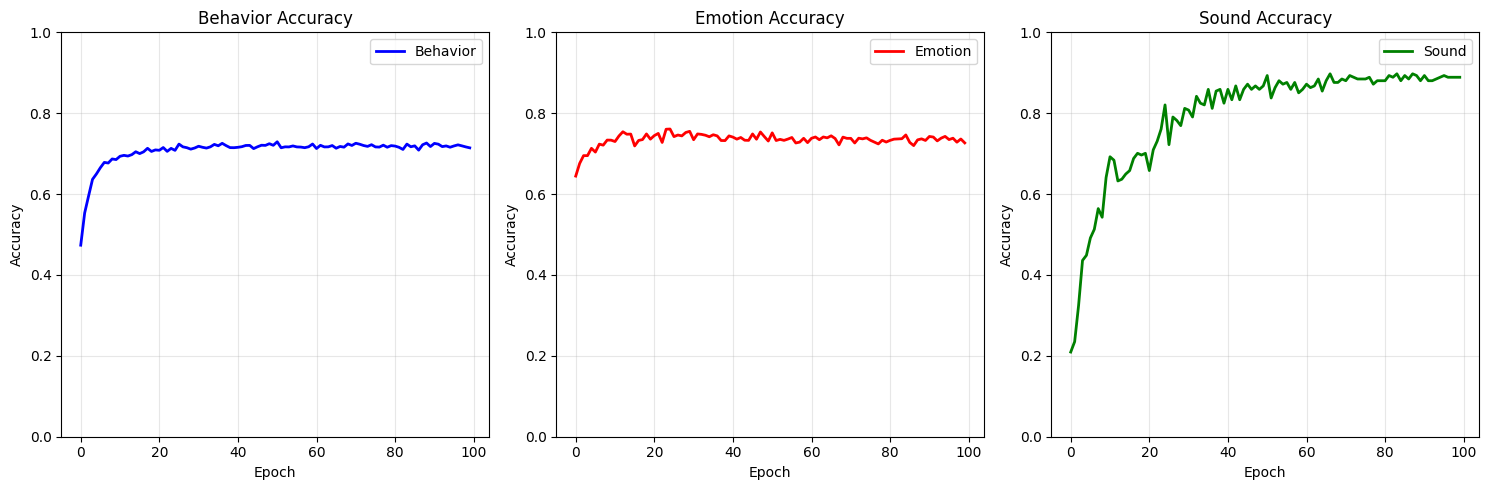

In [ ]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import Wav2Vec2Model

# ===============================
# CONFIG
# ===============================

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BATCH_SIZE = 16
LR = 1e-4

# ===============================
# MODEL DEFINITIONS
# ===============================

class VideoMultiBackbone(nn.Module):
    def __init__(self, num_behavior_classes, num_emotion_classes, num_patella_classes):
        super().__init__()

        # Behavior backbone
        self.behavior_backbone = models.resnet34(weights=None)
        self.behavior_backbone.fc = nn.Identity()
        self.behavior_head = nn.Linear(512, num_behavior_classes)

        # Emotion backbone
        self.emotion_backbone = models.resnet34(weights=None)
        self.emotion_backbone.fc = nn.Identity()
        self.emotion_head = nn.Linear(512, num_emotion_classes)

        # Patella backbone
        self.patella_backbone = models.resnet34(weights=None)
        self.patella_backbone.fc = nn.Identity()
        self.patella_head = nn.Linear(512 + 8, num_patella_classes)  # keypoints concat

    def forward(self, x, keypoints=None, task="behavior"):

        if task == "behavior":
            feat = self.behavior_backbone(x)
            return self.behavior_head(feat)

        elif task == "emotion":
            feat = self.emotion_backbone(x)
            return self.emotion_head(feat)

        elif task == "patella":
            feat = self.patella_backbone(x)
            feat = torch.cat([feat, keypoints], dim=1)
            return self.patella_head(feat)

        else:
            raise ValueError("Invalid task")


class AudioModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_values):
        outputs = self.wav2vec(input_values)
        pooled = outputs.last_hidden_state.mean(dim=1)
        return self.classifier(pooled)


# ===============================
# DUMMY DATASETS (구조 예시)
# ===============================

class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, task):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.task = task

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)
        label = torch.randint(0, 5, (1,)).item()
        return image, label


class EmotionDataset(Dataset):
    def __init__(self, dataframe, root_dir):
        self.dataframe = dataframe
        self.root_dir = root_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)
        audio = torch.randn(16000)
        label = torch.randint(0, 5, (1,)).item()
        return image, audio, label


class PatellaDataset(Dataset):
    def __init__(self, dataframe, img_dir, json_dir):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.json_dir = json_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)
        keypoints = torch.randn(8)
        label = torch.randint(0, 3, (1,)).item()
        return image, keypoints, label


# ===============================
# TRAIN FUNCTION (Sequential Loading)
# ===============================

def train():

    video_model = VideoMultiBackbone(5, 5, 3)
    audio_model = AudioModel(5)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        list(video_model.parameters()) +
        list(audio_model.parameters()),
        lr=LR
    )

    scaler = GradScaler()

    for epoch in range(EPOCHS):

        print(f"\n========= Epoch {epoch+1}/{EPOCHS} =========\n")

        # ==================================================
        # 1️⃣ Behavior
        # ==================================================

        print("Behavior Training")

        video_model.to(DEVICE)
        video_model.train()

        behavior_dataset = ImageDataset(None, None, task="behavior")
        behavior_loader = DataLoader(
            behavior_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        for images, labels in behavior_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with autocast():
                outputs = video_model(images, task="behavior")
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        del behavior_loader, behavior_dataset
        gc.collect()
        torch.cuda.empty_cache()


        # ==================================================
        # 2️⃣ Emotion (Audio GPU ON)
        # ==================================================

        print("Emotion Training")

        audio_model.to(DEVICE)
        audio_model.train()

        emotion_dataset = EmotionDataset(None, None)
        emotion_loader = DataLoader(
            emotion_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        for images, audios, labels in emotion_loader:
            images = images.to(DEVICE)
            audios = audios.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with autocast():
                video_out = video_model(images, task="emotion")
                audio_out = audio_model(audios)
                outputs = (video_out + audio_out) / 2
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Emotion 끝 → Audio GPU 제거
        audio_model.to("cpu")

        del emotion_loader, emotion_dataset
        gc.collect()
        torch.cuda.empty_cache()


        # ==================================================
        # 3️⃣ Patella
        # ==================================================

        print("Patella Training")

        patella_dataset = PatellaDataset(None, None, None)
        patella_loader = DataLoader(
            patella_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        for images, keypoints, labels in patella_loader:
            images = images.to(DEVICE)
            keypoints = keypoints.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with autocast():
                outputs = video_model(images, keypoints=keypoints, task="patella")
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        del patella_loader, patella_dataset
        gc.collect()
        torch.cuda.empty_cache()


        # ==================================================
        # Save
        # ==================================================

        torch.save({
            "video_model": video_model.state_dict(),
            "audio_model": audio_model.state_dict()
        }, f"checkpoint_epoch_{epoch+1}.pth")

    print("Training Finished.")


if __name__ == "__main__":
    train()

## Test

In [4]:
import os
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor, get_linear_schedule_with_warmup
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import librosa
import numpy as np
from collections import defaultdict, Counter
from sklearn.utils.class_weight import compute_class_weight

AUDIO_MODEL_NAME = "facebook/wav2vec2-base"
FEATURE_EXTRACTOR = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_NAME)

class VideoMultiBackbone(nn.Module):
    def __init__(self, num_b, num_e):
        super().__init__()
        
        backbone_b = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features_b = backbone_b.fc.in_features
        backbone_b.fc = nn.Identity()
        self.behavior_backbone = backbone_b
        self.behavior_head = nn.Linear(in_features_b, num_b)
        
        backbone_e = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features_e = backbone_e.fc.in_features
        backbone_e.fc = nn.Identity()
        self.emotion_backbone = backbone_e
        self.emotion_head = nn.Linear(in_features_e, num_e)
    
    def forward(self, x, task):
        if task == "behavior":
            feat = self.behavior_backbone(x)
            return self.behavior_head(feat)
        elif task == "emotion":
            feat = self.emotion_backbone(x)
            return self.emotion_head(feat)
        else:
            raise ValueError("Task must be 'behavior' or 'emotion'")
        
class AudioModel(nn.Module):
    def __init__(self, num_classes, freeze_backbone=False):  # 🔥 기본값 False
        super().__init__()
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(
            AUDIO_MODEL_NAME,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
        # 🔥 Freeze 옵션 (기본: 전체 학습)
        if freeze_backbone:
            for param in self.model.wav2vec2.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        return self.model(input_values=x).logits

def test():
    from transformers import Wav2Vec2FeatureExtractor
    FEATURE_EXTRACTOR = Wav2Vec2FeatureExtractor.from_pretrained(
        "facebook/wav2vec2-base"
    )

    DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 16
    SR = 16000
    MAX_AUDIO_LEN = SR * 5

    print("🔎 Loading best model...")
    checkpoint = torch.load("pet_omni_best.pth", map_location=DEVICE)

    behavior_label_to_id = checkpoint["behavior_label_to_id"]
    emotion_label_to_id = checkpoint["emotion_label_to_id"]
    sound_label_to_id = checkpoint["sound_label_to_id"]

    # -----------------------------
    # 모델 복원
    # -----------------------------
    video_model = VideoMultiBackbone(
        len(behavior_label_to_id),
        len(emotion_label_to_id)
    ).to(DEVICE)

    audio_model = AudioModel(
        len(sound_label_to_id)
    ).to(DEVICE)

    video_model.load_state_dict(checkpoint["video_model"])
    audio_model.load_state_dict(checkpoint["audio_model"])

    video_model.eval()
    audio_model.eval()

    print("📦 Loading TEST datasets...")

    TEST_DIR = os.path.join("files", "work", "omni_dataset", "test")

    # -----------------------------
    # Train 의존 없는 Dataset 정의
    # -----------------------------
    class TestImageDataset(Dataset):
        def __init__(self, task_dir, label_to_id):
            self.samples = []
            self.label_to_id = label_to_id

            for label in os.listdir(task_dir):
                if label not in label_to_id:
                    continue

                label_dir = os.path.join(task_dir, label)
                for file in os.listdir(label_dir):
                    if file.lower().endswith(('.jpg','.png','.jpeg')):
                        self.samples.append(
                            (os.path.join(label_dir,file),
                             label_to_id[label])
                        )

            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485,0.456,0.406],
                    [0.229,0.224,0.225]
                )
            ])

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            path, label_id = self.samples[idx]
            img = Image.open(path).convert("RGB")
            img = self.transform(img)
            return img, label_id


    class TestAudioDataset(Dataset):
        def __init__(self, task_dir, label_to_id):
            self.samples = []
            self.label_to_id = label_to_id

            for label in os.listdir(task_dir):
                if label not in label_to_id:
                    continue

                label_dir = os.path.join(task_dir, label)
                for file in os.listdir(label_dir):
                    if file.lower().endswith(('.wav','.mp3','.m4a')):
                        self.samples.append(
                            (os.path.join(label_dir,file),
                             label_to_id[label])
                        )

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            path, label_id = self.samples[idx]
            waveform, _ = librosa.load(path, sr=SR, mono=True)

            if len(waveform) > MAX_AUDIO_LEN:
                waveform = waveform[:MAX_AUDIO_LEN]
            else:
                waveform = np.pad(
                    waveform,
                    (0, MAX_AUDIO_LEN - len(waveform))
                )

            inputs = FEATURE_EXTRACTOR(
                waveform,
                sampling_rate=SR,
                return_tensors="pt"
            )

            return inputs.input_values.squeeze(0), label_id


    # -----------------------------
    # Loader
    # -----------------------------
    behavior_loader = DataLoader(
        TestImageDataset(
            os.path.join(TEST_DIR,"behavior"),
            behavior_label_to_id
        ),
        BATCH_SIZE, False
    )

    emotion_loader = DataLoader(
        TestImageDataset(
            os.path.join(TEST_DIR,"emotion"),
            emotion_label_to_id
        ),
        BATCH_SIZE, False
    )

    sound_loader = DataLoader(
        TestAudioDataset(
            os.path.join(TEST_DIR,"sound"),
            sound_label_to_id
        ),
        BATCH_SIZE, False
    )

    # -----------------------------
    # Evaluation
    # -----------------------------
    def evaluate(loader, task):
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                if task in ["behavior","emotion"]:
                    logits = video_model(x, task)
                else:
                    logits = audio_model(x)

                pred = logits.argmax(-1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        return correct / total if total > 0 else 0


    acc_b = evaluate(behavior_loader, "behavior")
    acc_e = evaluate(emotion_loader, "emotion")
    acc_s = evaluate(sound_loader, "sound")

    avg_acc = (acc_b + acc_e + acc_s) / 3

    print("\n📊 TEST Results:")
    print(f"  Behavior Acc: {acc_b:.4f} ({acc_b*100:.1f}%)")
    print(f"  Emotion Acc:  {acc_e:.4f} ({acc_e*100:.1f}%)")
    print(f"  Sound Acc:    {acc_s:.4f} ({acc_s*100:.1f}%)")
    print(f"  Average Acc:  {avg_acc:.4f} ({avg_acc*100:.1f}%)")


if __name__ == "__main__":
    test()

🔎 Loading best model...


Loading weights: 100%|██████████| 211/211 [00:00<00:00, 658.49it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_hid.weight           | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
projector.weight             | MISSING    | 
classifier.bias              | MISSING    | 
projector.bias               | MISSING    | 
classifier.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because miss

📦 Loading TEST datasets...

📊 TEST Results:
  Behavior Acc: 0.7273 (72.7%)
  Emotion Acc:  0.7525 (75.2%)
  Sound Acc:    0.9138 (91.4%)
  Average Acc:  0.7979 (79.8%)
